# Conditional Average Treatment Effects (CATE) with DoWhy and EconML

This is an experimental feature where we use [EconML](https://github.com/microsoft/econml) methods from DoWhy. Using EconML allows CATE estimation using different methods. 

All four steps of causal inference in DoWhy remain the same: model, identify, estimate, and refute. The key difference is that we now call econml methods in the estimation step. There is also a simpler example using linear regression to understand the intuition behind CATE estimators. 

All datasets are generated using linear structural equations.



In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import logging

import dowhy
from dowhy import CausalModel
import dowhy.datasets

import econml
import warnings
warnings.filterwarnings('ignore')

BETA = 10

In [3]:
data = dowhy.datasets.linear_dataset(BETA, num_common_causes=4, num_samples=10000,
                                    num_instruments=2, num_effect_modifiers=2,
                                     num_treatments=1,
                                    treatment_is_binary=False,
                                    num_discrete_common_causes=2,
                                    num_discrete_effect_modifiers=0,
                                    one_hot_encode=False)
df=data['df']
print(df.head())
print("True causal estimate is", data["ate"])

         X0        X1   Z0        Z1        W0        W1 W2 W3         v0  \
0 -0.569104 -0.111816  1.0  0.948867  2.352649 -1.969283  2  2  35.873612   
1 -0.584110 -0.047394  1.0  0.070832 -0.324809 -2.042192  0  1   5.782131   
2 -0.421058  0.467609  1.0  0.547110 -0.512548  0.219448  0  1  18.454465   
3 -1.233570 -0.343834  1.0  0.606468 -1.829665 -1.701919  2  0  15.093029   
4 -0.556962  0.775002  0.0  0.694075  0.232821 -0.530389  0  1   8.012448   

            y  
0  326.733195  
1   47.550235  
2  199.052868  
3  104.492695  
4   92.924773  
True causal estimate is 8.269613382989386


In [4]:
model = CausalModel(data=data["df"], 
                    treatment=data["treatment_name"], outcome=data["outcome_name"], 
                    graph=data["gml_graph"])

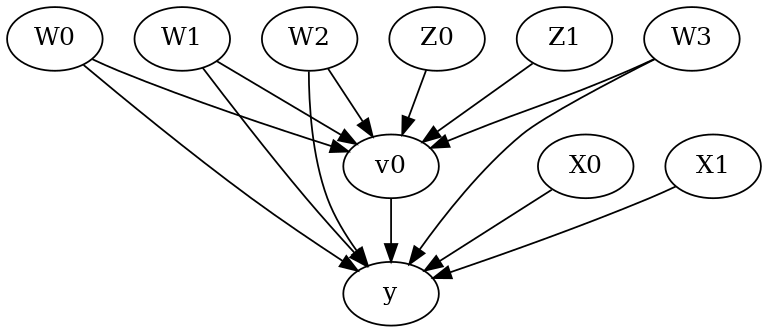

In [5]:
model.view_model()
from IPython.display import Image, display
display(Image(filename="causal_model.png"))

In [6]:
identified_estimand= model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W3,W0,W1,W2])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W3,W0,W1,W2,U) = P(y|v0,W3,W0,W1,W2)

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                              -1⎤
 ⎢    d        ⎛    d          ⎞  ⎥
E⎢─────────(y)⋅⎜─────────([v₀])⎟  ⎥
 ⎣d[Z₁  Z₀]    ⎝d[Z₁  Z₀]      ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z1,Z0})
Estimand assumption 2, Exclusion: If we remove {Z1,Z0}→{v0}, then ¬({Z1,Z0}→y)

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



## Linear Model 
First, let us build some intuition using a linear model for estimating CATE. The effect modifiers (that lead to a heterogeneous treatment effect) can be modeled as interaction terms with the treatment. Thus, their value modulates the effect of treatment. 

Below the estimated effect of changing treatment from 0 to 1. 

In [7]:
linear_estimate = model.estimate_effect(identified_estimand, 
                                        method_name="backdoor.linear_regression",
                                       control_value=0,
                                       treatment_value=1)
print(linear_estimate) 

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W3,W0,W1,W2])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W3,W0,W1,W2,U) = P(y|v0,W3,W0,W1,W2)

## Realized estimand
b: y~v0+W3+W0+W1+W2+v0*X0+v0*X1
Target units: ate

## Estimate
Mean value: 8.26994312080011



## EconML methods
We now move to the more advanced methods from the EconML package for estimating CATE.

First, let us look at the double machine learning estimator. Method_name corresponds to the fully qualified name of the class that we want to use. For double ML, it is "econml.dml.DML". 

Target units defines the units over which the causal estimate is to be computed. This can be a lambda function filter on the original dataframe, a new Pandas dataframe, or a string corresponding to the three main kinds of target units ("ate", "att" and "atc"). Below we show an example of a lambda function. 

Method_params are passed directly to EconML. For details on allowed parameters, refer to the EconML documentation. 

In [8]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor
dml_estimate = model.estimate_effect(identified_estimand, method_name="backdoor.econml.dml.DML",
                                     control_value = 0,
                                     treatment_value = 1,
                                 target_units = lambda df: df["X0"]>1,  # condition used for CATE
                                 confidence_intervals=False,
                                method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final":LassoCV(fit_intercept=False), 
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=False)},
                                               "fit_params":{}})
print(dml_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W3,W0,W1,W2])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W3,W0,W1,W2,U) = P(y|v0,W3,W0,W1,W2)

## Realized estimand
b: y~v0+W3+W0+W1+W2 | X0,X1
Target units: Data subset defined by a function

## Estimate
Mean value: 11.090224805371125
Effect estimates: [[11.05624297]
 [15.52266413]
 [11.14498172]
 [ 3.63140204]
 [15.19427679]
 [11.51201972]
 [ 9.89980187]
 [11.07686779]
 [15.4822641 ]
 [ 8.47179279]
 [15.84750182]
 [ 6.99189115]
 [10.47234749]
 [16.66045188]
 [12.52963908]
 [11.04685954]
 [14.27067432]
 [11.49801965]
 [10.74402886]
 [16.84015227]
 [18.51037728]
 [17.47165957]
 [10.16408821]
 [16.1217663 ]
 [11.21098917]
 [15.01711053]
 [ 6.32769074]
 [13.51410965]
 [16.05754851]
 [10.84509657]
 [ 9.35854428]
 [12.65206713]
 [13.20521577]
 [ 8.218

In [9]:
print("True causal estimate is", data["ate"])

True causal estimate is 8.269613382989386


In [10]:
dml_estimate = model.estimate_effect(identified_estimand, method_name="backdoor.econml.dml.DML",
                                     control_value = 0,
                                     treatment_value = 1,
                                 target_units = 1,  # condition used for CATE
                                 confidence_intervals=False,
                                method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final":LassoCV(fit_intercept=False), 
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=True)},
                                               "fit_params":{}})
print(dml_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W3,W0,W1,W2])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W3,W0,W1,W2,U) = P(y|v0,W3,W0,W1,W2)

## Realized estimand
b: y~v0+W3+W0+W1+W2 | X0,X1
Target units: 

## Estimate
Mean value: 8.277104140904896
Effect estimates: [[ 8.69736975]
 [ 8.86990749]
 [10.73564333]
 ...
 [11.87314289]
 [ 9.97673046]
 [ 4.52651411]]



### CATE Object and Confidence Intervals
EconML provides its own methods to compute confidence intervals. Using BootstrapInference in the example below. 

In [11]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor
from econml.inference import BootstrapInference
dml_estimate = model.estimate_effect(identified_estimand, 
                                     method_name="backdoor.econml.dml.DML",
                                     target_units = "ate",
                                     confidence_intervals=True,
                                     method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final": LassoCV(fit_intercept=False), 
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=True)},
                                               "fit_params":{
                                                               'inference': BootstrapInference(n_bootstrap_samples=100, n_jobs=-1),
                                                            }
                                              })
print(dml_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W3,W0,W1,W2])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W3,W0,W1,W2,U) = P(y|v0,W3,W0,W1,W2)

## Realized estimand
b: y~v0+W3+W0+W1+W2 | X0,X1
Target units: ate

## Estimate
Mean value: 8.28688504015884
Effect estimates: [[ 8.73403574]
 [ 8.91234384]
 [10.82468078]
 ...
 [12.04358753]
 [10.05989413]
 [ 4.40359633]]
95.0% confidence interval: [[[ 8.80875979  8.99055407 10.94034918 ... 12.12030118 10.14573395
    4.25225878]]

 [[ 8.96662975  9.15543942 11.17118376 ... 12.49617283 10.35003949
    4.53870841]]]



### Can provide a new inputs as target units and estimate CATE on them.

In [12]:
test_cols= data['effect_modifier_names'] # only need effect modifiers' values
test_arr = [np.random.uniform(0,1, 10) for _ in range(len(test_cols))] # all variables are sampled uniformly, sample of 10
test_df = pd.DataFrame(np.array(test_arr).transpose(), columns=test_cols)
dml_estimate = model.estimate_effect(identified_estimand, 
                                     method_name="backdoor.econml.dml.DML",
                                     target_units = test_df,
                                     confidence_intervals=False,
                                     method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final":LassoCV(), 
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=True)},
                                               "fit_params":{}
                                              })
print(dml_estimate.cate_estimates)

[[10.81287872]
 [11.02543945]
 [13.60146227]
 [10.29809706]
 [12.74725011]
 [13.17904762]
 [10.44273848]
 [13.29746957]
 [12.40923718]
 [13.58141668]]


### Can also retrieve the raw EconML estimator object for any further operations

In [13]:
print(dml_estimate._estimator_object)

## Works with any EconML method
In addition to double machine learning, below we example analyses using orthogonal forests, DRLearner (bug to fix), and neural network-based instrumental variables. 

### Binary treatment, Binary outcome

In [14]:
data_binary = dowhy.datasets.linear_dataset(BETA, num_common_causes=4, num_samples=10000,
                                    num_instruments=2, num_effect_modifiers=2,
                                    treatment_is_binary=True, outcome_is_binary=True)
# convert boolean values to {0,1} numeric
data_binary['df'].v0 = data_binary['df'].v0.astype(int)
data_binary['df'].y = data_binary['df'].y.astype(int)
print(data_binary['df'])

model_binary = CausalModel(data=data_binary["df"], 
                    treatment=data_binary["treatment_name"], outcome=data_binary["outcome_name"], 
                    graph=data_binary["gml_graph"])
identified_estimand_binary = model_binary.identify_effect(proceed_when_unidentifiable=True)

            X0        X1   Z0        Z1        W0        W1        W2  \
0    -0.002805  1.925189  0.0  0.739020 -1.565300 -1.851948 -0.807573   
1    -1.957463  0.698999  0.0  0.903542 -0.798236 -3.853567 -1.632114   
2     0.556121 -0.727609  0.0  0.685195 -1.591182 -1.706548 -1.636245   
3     1.881743  1.103200  0.0  0.198438 -0.589850  0.678840  1.390995   
4     0.131292 -0.211034  0.0  0.208439  0.931848 -1.989639 -1.652803   
...        ...       ...  ...       ...       ...       ...       ...   
9995 -0.847167  0.275015  0.0  0.097338  0.552854 -0.450956 -2.686354   
9996 -1.704886 -0.525567  0.0  0.664755  1.683410 -1.124136 -1.035533   
9997 -0.303357  0.714770  0.0  0.124470  0.695319 -1.844457 -2.148084   
9998 -1.760817 -1.521197  0.0  0.093409  0.822162 -0.178786 -3.151984   
9999  0.085657 -0.225739  0.0  0.827341 -2.292064  0.061291 -0.029777   

            W3  v0  y  
0     1.676222   0  0  
1    -0.223066   0  0  
2    -0.607069   0  0  
3    -0.145792   1  1  
4  

#### Using DRLearner estimator

In [15]:
from sklearn.linear_model import LogisticRegressionCV
#todo needs binary y
drlearner_estimate = model_binary.estimate_effect(identified_estimand_binary, 
                                method_name="backdoor.econml.dr.LinearDRLearner",
                                confidence_intervals=False,
                                method_params={"init_params":{
                                                    'model_propensity': LogisticRegressionCV(cv=3, solver='lbfgs', multi_class='auto')
                                                    },
                                               "fit_params":{}
                                              })
print(drlearner_estimate)
print("True causal estimate is", data_binary["ate"])

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W3,W0,W1,W2])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W3,W0,W1,W2,U) = P(y|v0,W3,W0,W1,W2)

## Realized estimand
b: y~v0+W3+W0+W1+W2 | X0,X1
Target units: ate

## Estimate
Mean value: 0.5656879317359575
Effect estimates: [[0.69713619]
 [0.37393408]
 [0.69094281]
 ...
 [0.61388861]
 [0.32950326]
 [0.63931974]]

True causal estimate is 0.4918


### Instrumental Variable Method

In [16]:
import keras
dims_zx = len(model.get_instruments())+len(model.get_effect_modifiers())
dims_tx = len(model._treatment)+len(model.get_effect_modifiers())
treatment_model = keras.Sequential([keras.layers.Dense(128, activation='relu', input_shape=(dims_zx,)), # sum of dims of Z and X 
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(64, activation='relu'),
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(32, activation='relu'),
                                    keras.layers.Dropout(0.17)])                
response_model = keras.Sequential([keras.layers.Dense(128, activation='relu', input_shape=(dims_tx,)), # sum of dims of T and X
                                    keras.layers.Dropout(0.17), 
                                    keras.layers.Dense(64, activation='relu'),
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(32, activation='relu'),
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(1)])

deepiv_estimate = model.estimate_effect(identified_estimand, 
                                        method_name="iv.econml.iv.nnet.DeepIV",
                                        target_units = lambda df: df["X0"]>-1, 
                                        confidence_intervals=False,
                                method_params={"init_params":{'n_components': 10, # Number of gaussians in the mixture density networks
                                                              'm': lambda z, x: treatment_model(keras.layers.concatenate([z, x])), # Treatment model,
                                                              "h": lambda t, x: response_model(keras.layers.concatenate([t, x])), # Response model
                                                              'n_samples': 1, # Number of samples used to estimate the response
                                                              'first_stage_options': {'epochs':25},
                                                              'second_stage_options': {'epochs':25}
                                                             },
                                               "fit_params":{}})
print(deepiv_estimate)

2023-05-27 02:09:20.141276: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-27 02:09:20.290155: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-05-27 02:09:20.290201: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


2023-05-27 02:09:21.071615: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-05-27 02:09:21.071751: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-05-27 02:09:21.071763: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


2023-05-27 02:09:21.924763: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-05-27 02:09:21.924799: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-05-27 02:09:21.924825: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (73f23c59638e): /proc/driver/nvidia/version does not exist
2023-05-27 02:09:21.925371: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/25


  1/313 [..............................] - ETA: 6:12 - loss: 170.0970

 31/313 [=>............................] - ETA: 0s - loss: 56.9033   

 61/313 [====>.........................] - ETA: 0s - loss: 31.7328

 91/313 [=======>......................] - ETA: 0s - loss: 22.7993

120/313 [==========>...................] - ETA: 0s - loss: 18.3575

149/313 [=============>................] - ETA: 0s - loss: 15.6143

176/313 [===============>..............] - ETA: 0s - loss: 13.8741

208/313 [==================>...........] - ETA: 0s - loss: 12.3842

239/313 [=====================>........] - ETA: 0s - loss: 11.3159

270/313 [========================>.....] - ETA: 0s - loss: 10.4915

300/313 [===========================>..] - ETA: 0s - loss: 9.8527 

313/313 [==============================] - 2s 2ms/step - loss: 9.6145


Epoch 2/25


  1/313 [..............................] - ETA: 0s - loss: 4.0641

 31/313 [=>............................] - ETA: 0s - loss: 4.0521

 62/313 [====>.........................] - ETA: 0s - loss: 4.0061

 94/313 [========>.....................] - ETA: 0s - loss: 3.9947

125/313 [==========>...................] - ETA: 0s - loss: 3.9842

156/313 [=============>................] - ETA: 0s - loss: 3.9675

187/313 [================>.............] - ETA: 0s - loss: 3.9330

216/313 [===================>..........] - ETA: 0s - loss: 3.8985

247/313 [======================>.......] - ETA: 0s - loss: 3.8676

279/313 [=========================>....] - ETA: 0s - loss: 3.8297

310/313 [============================>.] - ETA: 0s - loss: 3.7834

313/313 [==============================] - 1s 2ms/step - loss: 3.7787


Epoch 3/25


  1/313 [..............................] - ETA: 0s - loss: 3.3814

 33/313 [==>...........................] - ETA: 0s - loss: 3.2494

 63/313 [=====>........................] - ETA: 0s - loss: 3.1782

 94/313 [========>.....................] - ETA: 0s - loss: 3.1558

124/313 [==========>...................] - ETA: 0s - loss: 3.1287

155/313 [=============>................] - ETA: 0s - loss: 3.1034

186/313 [================>.............] - ETA: 0s - loss: 3.0798

218/313 [===================>..........] - ETA: 0s - loss: 3.0681

249/313 [======================>.......] - ETA: 0s - loss: 3.0478

279/313 [=========================>....] - ETA: 0s - loss: 3.0266

309/313 [============================>.] - ETA: 0s - loss: 3.0164

313/313 [==============================] - 1s 2ms/step - loss: 3.0168


Epoch 4/25


  1/313 [..............................] - ETA: 0s - loss: 2.7781

 32/313 [==>...........................] - ETA: 0s - loss: 2.9178

 62/313 [====>.........................] - ETA: 0s - loss: 2.8899

 93/313 [=======>......................] - ETA: 0s - loss: 2.8900

121/313 [==========>...................] - ETA: 0s - loss: 2.8898

148/313 [=============>................] - ETA: 0s - loss: 2.8826

175/313 [===============>..............] - ETA: 0s - loss: 2.8713

206/313 [==================>...........] - ETA: 0s - loss: 2.8715

237/313 [=====================>........] - ETA: 0s - loss: 2.8671

267/313 [========================>.....] - ETA: 0s - loss: 2.8622

296/313 [===========================>..] - ETA: 0s - loss: 2.8667

313/313 [==============================] - 1s 2ms/step - loss: 2.8655


Epoch 5/25


  1/313 [..............................] - ETA: 0s - loss: 2.9597

 33/313 [==>...........................] - ETA: 0s - loss: 2.7929

 63/313 [=====>........................] - ETA: 0s - loss: 2.8168

 94/313 [========>.....................] - ETA: 0s - loss: 2.8164

125/313 [==========>...................] - ETA: 0s - loss: 2.8187

156/313 [=============>................] - ETA: 0s - loss: 2.8125

186/313 [================>.............] - ETA: 0s - loss: 2.8088

217/313 [===================>..........] - ETA: 0s - loss: 2.8119

248/313 [======================>.......] - ETA: 0s - loss: 2.8029

278/313 [=========================>....] - ETA: 0s - loss: 2.8033

309/313 [============================>.] - ETA: 0s - loss: 2.8046

313/313 [==============================] - 1s 2ms/step - loss: 2.8031


Epoch 6/25


  1/313 [..............................] - ETA: 0s - loss: 2.6859

 32/313 [==>...........................] - ETA: 0s - loss: 2.7874

 63/313 [=====>........................] - ETA: 0s - loss: 2.7901

 93/313 [=======>......................] - ETA: 0s - loss: 2.7984

123/313 [==========>...................] - ETA: 0s - loss: 2.7907

152/313 [=============>................] - ETA: 0s - loss: 2.7938

182/313 [================>.............] - ETA: 0s - loss: 2.7819

213/313 [===================>..........] - ETA: 0s - loss: 2.7761

243/313 [======================>.......] - ETA: 0s - loss: 2.7707

274/313 [=========================>....] - ETA: 0s - loss: 2.7685

305/313 [============================>.] - ETA: 0s - loss: 2.7699

313/313 [==============================] - 1s 2ms/step - loss: 2.7704


Epoch 7/25


  1/313 [..............................] - ETA: 0s - loss: 2.8354

 32/313 [==>...........................] - ETA: 0s - loss: 2.7856

 63/313 [=====>........................] - ETA: 0s - loss: 2.7486

 94/313 [========>.....................] - ETA: 0s - loss: 2.7616

124/313 [==========>...................] - ETA: 0s - loss: 2.7500

154/313 [=============>................] - ETA: 0s - loss: 2.7504

185/313 [================>.............] - ETA: 0s - loss: 2.7479

217/313 [===================>..........] - ETA: 0s - loss: 2.7423

247/313 [======================>.......] - ETA: 0s - loss: 2.7412

277/313 [=========================>....] - ETA: 0s - loss: 2.7404

308/313 [============================>.] - ETA: 0s - loss: 2.7386

313/313 [==============================] - 1s 2ms/step - loss: 2.7402


Epoch 8/25


  1/313 [..............................] - ETA: 0s - loss: 2.5063

 32/313 [==>...........................] - ETA: 0s - loss: 2.7186

 63/313 [=====>........................] - ETA: 0s - loss: 2.7300

 91/313 [=======>......................] - ETA: 0s - loss: 2.7269

122/313 [==========>...................] - ETA: 0s - loss: 2.7276

152/313 [=============>................] - ETA: 0s - loss: 2.7229

183/313 [================>.............] - ETA: 0s - loss: 2.7234

214/313 [===================>..........] - ETA: 0s - loss: 2.7170

245/313 [======================>.......] - ETA: 0s - loss: 2.7194

277/313 [=========================>....] - ETA: 0s - loss: 2.7176

308/313 [============================>.] - ETA: 0s - loss: 2.7180

313/313 [==============================] - 1s 2ms/step - loss: 2.7175


Epoch 9/25


  1/313 [..............................] - ETA: 0s - loss: 2.6371

 32/313 [==>...........................] - ETA: 0s - loss: 2.7026

 65/313 [=====>........................] - ETA: 0s - loss: 2.6990

 96/313 [========>.....................] - ETA: 0s - loss: 2.6996

128/313 [===========>..................] - ETA: 0s - loss: 2.7004

157/313 [==============>...............] - ETA: 0s - loss: 2.6975

189/313 [=================>............] - ETA: 0s - loss: 2.7074

220/313 [====================>.........] - ETA: 0s - loss: 2.6994

250/313 [======================>.......] - ETA: 0s - loss: 2.6924

281/313 [=========================>....] - ETA: 0s - loss: 2.6915

312/313 [============================>.] - ETA: 0s - loss: 2.6941

313/313 [==============================] - 1s 2ms/step - loss: 2.6938


Epoch 10/25


  1/313 [..............................] - ETA: 0s - loss: 2.7118

 33/313 [==>...........................] - ETA: 0s - loss: 2.7170

 64/313 [=====>........................] - ETA: 0s - loss: 2.6969

 95/313 [========>.....................] - ETA: 0s - loss: 2.7009

126/313 [===========>..................] - ETA: 0s - loss: 2.7113

157/313 [==============>...............] - ETA: 0s - loss: 2.7102

188/313 [=================>............] - ETA: 0s - loss: 2.7047

217/313 [===================>..........] - ETA: 0s - loss: 2.6983

247/313 [======================>.......] - ETA: 0s - loss: 2.6946

277/313 [=========================>....] - ETA: 0s - loss: 2.6892

307/313 [============================>.] - ETA: 0s - loss: 2.6900

313/313 [==============================] - 1s 2ms/step - loss: 2.6885


Epoch 11/25


  1/313 [..............................] - ETA: 0s - loss: 2.7275

 33/313 [==>...........................] - ETA: 0s - loss: 2.7094

 63/313 [=====>........................] - ETA: 0s - loss: 2.6953

 94/313 [========>.....................] - ETA: 0s - loss: 2.6998

126/313 [===========>..................] - ETA: 0s - loss: 2.7002

157/313 [==============>...............] - ETA: 0s - loss: 2.6951

187/313 [================>.............] - ETA: 0s - loss: 2.6915

217/313 [===================>..........] - ETA: 0s - loss: 2.6906

247/313 [======================>.......] - ETA: 0s - loss: 2.6884

277/313 [=========================>....] - ETA: 0s - loss: 2.6828

307/313 [============================>.] - ETA: 0s - loss: 2.6874

313/313 [==============================] - 1s 2ms/step - loss: 2.6868


Epoch 12/25


  1/313 [..............................] - ETA: 0s - loss: 2.6593

 33/313 [==>...........................] - ETA: 0s - loss: 2.6680

 64/313 [=====>........................] - ETA: 0s - loss: 2.6528

 96/313 [========>.....................] - ETA: 0s - loss: 2.6615

129/313 [===========>..................] - ETA: 0s - loss: 2.6652

159/313 [==============>...............] - ETA: 0s - loss: 2.6632

190/313 [=================>............] - ETA: 0s - loss: 2.6593

221/313 [====================>.........] - ETA: 0s - loss: 2.6556

251/313 [=======================>......] - ETA: 0s - loss: 2.6578

281/313 [=========================>....] - ETA: 0s - loss: 2.6592

309/313 [============================>.] - ETA: 0s - loss: 2.6633

313/313 [==============================] - 1s 2ms/step - loss: 2.6631


Epoch 13/25


  1/313 [..............................] - ETA: 0s - loss: 2.7975

 33/313 [==>...........................] - ETA: 0s - loss: 2.6748

 64/313 [=====>........................] - ETA: 0s - loss: 2.6568

 95/313 [========>.....................] - ETA: 0s - loss: 2.6417

126/313 [===========>..................] - ETA: 0s - loss: 2.6397

157/313 [==============>...............] - ETA: 0s - loss: 2.6292

187/313 [================>.............] - ETA: 0s - loss: 2.6282

217/313 [===================>..........] - ETA: 0s - loss: 2.6327

248/313 [======================>.......] - ETA: 0s - loss: 2.6346

279/313 [=========================>....] - ETA: 0s - loss: 2.6370

310/313 [============================>.] - ETA: 0s - loss: 2.6343

313/313 [==============================] - 1s 2ms/step - loss: 2.6332


Epoch 14/25


  1/313 [..............................] - ETA: 0s - loss: 2.4749

 32/313 [==>...........................] - ETA: 0s - loss: 2.6114

 63/313 [=====>........................] - ETA: 0s - loss: 2.6304

 94/313 [========>.....................] - ETA: 0s - loss: 2.6445

125/313 [==========>...................] - ETA: 0s - loss: 2.6370

155/313 [=============>................] - ETA: 0s - loss: 2.6447

185/313 [================>.............] - ETA: 0s - loss: 2.6374

214/313 [===================>..........] - ETA: 0s - loss: 2.6354

245/313 [======================>.......] - ETA: 0s - loss: 2.6280

276/313 [=========================>....] - ETA: 0s - loss: 2.6249

305/313 [============================>.] - ETA: 0s - loss: 2.6267

313/313 [==============================] - 1s 2ms/step - loss: 2.6287


Epoch 15/25


  1/313 [..............................] - ETA: 0s - loss: 2.6782

 32/313 [==>...........................] - ETA: 0s - loss: 2.6271

 63/313 [=====>........................] - ETA: 0s - loss: 2.6077

 94/313 [========>.....................] - ETA: 0s - loss: 2.6221

125/313 [==========>...................] - ETA: 0s - loss: 2.6243

156/313 [=============>................] - ETA: 0s - loss: 2.6264

187/313 [================>.............] - ETA: 0s - loss: 2.6325

218/313 [===================>..........] - ETA: 0s - loss: 2.6289

249/313 [======================>.......] - ETA: 0s - loss: 2.6232

279/313 [=========================>....] - ETA: 0s - loss: 2.6241

310/313 [============================>.] - ETA: 0s - loss: 2.6231

313/313 [==============================] - 1s 2ms/step - loss: 2.6233


Epoch 16/25


  1/313 [..............................] - ETA: 0s - loss: 2.5807

 32/313 [==>...........................] - ETA: 0s - loss: 2.5950

 63/313 [=====>........................] - ETA: 0s - loss: 2.6114

 94/313 [========>.....................] - ETA: 0s - loss: 2.6180

124/313 [==========>...................] - ETA: 0s - loss: 2.6111

155/313 [=============>................] - ETA: 0s - loss: 2.6193

186/313 [================>.............] - ETA: 0s - loss: 2.6129

217/313 [===================>..........] - ETA: 0s - loss: 2.6123

248/313 [======================>.......] - ETA: 0s - loss: 2.6087

279/313 [=========================>....] - ETA: 0s - loss: 2.6099

310/313 [============================>.] - ETA: 0s - loss: 2.6089

313/313 [==============================] - 1s 2ms/step - loss: 2.6072


Epoch 17/25


  1/313 [..............................] - ETA: 0s - loss: 2.5900

 32/313 [==>...........................] - ETA: 0s - loss: 2.5625

 63/313 [=====>........................] - ETA: 0s - loss: 2.5832

 94/313 [========>.....................] - ETA: 0s - loss: 2.5862

125/313 [==========>...................] - ETA: 0s - loss: 2.5946

156/313 [=============>................] - ETA: 0s - loss: 2.5976

187/313 [================>.............] - ETA: 0s - loss: 2.5974

218/313 [===================>..........] - ETA: 0s - loss: 2.5957

249/313 [======================>.......] - ETA: 0s - loss: 2.5973

280/313 [=========================>....] - ETA: 0s - loss: 2.5986

311/313 [============================>.] - ETA: 0s - loss: 2.6013

313/313 [==============================] - 1s 2ms/step - loss: 2.6025


Epoch 18/25


  1/313 [..............................] - ETA: 0s - loss: 2.4616

 34/313 [==>...........................] - ETA: 0s - loss: 2.5951

 66/313 [=====>........................] - ETA: 0s - loss: 2.5741

 96/313 [========>.....................] - ETA: 0s - loss: 2.6071

127/313 [===========>..................] - ETA: 0s - loss: 2.6103

159/313 [==============>...............] - ETA: 0s - loss: 2.6200

191/313 [=================>............] - ETA: 0s - loss: 2.6159

223/313 [====================>.........] - ETA: 0s - loss: 2.6090

254/313 [=======================>......] - ETA: 0s - loss: 2.6066

285/313 [==========================>...] - ETA: 0s - loss: 2.6030

313/313 [==============================] - 1s 2ms/step - loss: 2.6012


Epoch 19/25


  1/313 [..............................] - ETA: 0s - loss: 2.6938

 32/313 [==>...........................] - ETA: 0s - loss: 2.6640

 65/313 [=====>........................] - ETA: 0s - loss: 2.6350

 96/313 [========>.....................] - ETA: 0s - loss: 2.6069

126/313 [===========>..................] - ETA: 0s - loss: 2.6046

156/313 [=============>................] - ETA: 0s - loss: 2.5943

187/313 [================>.............] - ETA: 0s - loss: 2.5986

217/313 [===================>..........] - ETA: 0s - loss: 2.6014

247/313 [======================>.......] - ETA: 0s - loss: 2.6006

276/313 [=========================>....] - ETA: 0s - loss: 2.5981

307/313 [============================>.] - ETA: 0s - loss: 2.5983

313/313 [==============================] - 1s 2ms/step - loss: 2.5966


Epoch 20/25


  1/313 [..............................] - ETA: 0s - loss: 2.8309

 32/313 [==>...........................] - ETA: 0s - loss: 2.6122

 62/313 [====>.........................] - ETA: 0s - loss: 2.5688

 93/313 [=======>......................] - ETA: 0s - loss: 2.5797

124/313 [==========>...................] - ETA: 0s - loss: 2.5788

155/313 [=============>................] - ETA: 0s - loss: 2.5821

186/313 [================>.............] - ETA: 0s - loss: 2.5888

216/313 [===================>..........] - ETA: 0s - loss: 2.5850

247/313 [======================>.......] - ETA: 0s - loss: 2.5857

278/313 [=========================>....] - ETA: 0s - loss: 2.5876

308/313 [============================>.] - ETA: 0s - loss: 2.5887

313/313 [==============================] - 1s 2ms/step - loss: 2.5886


Epoch 21/25


  1/313 [..............................] - ETA: 0s - loss: 2.6467

 32/313 [==>...........................] - ETA: 0s - loss: 2.5768

 63/313 [=====>........................] - ETA: 0s - loss: 2.5720

 93/313 [=======>......................] - ETA: 0s - loss: 2.5714

124/313 [==========>...................] - ETA: 0s - loss: 2.5717

155/313 [=============>................] - ETA: 0s - loss: 2.5799

187/313 [================>.............] - ETA: 0s - loss: 2.5833

220/313 [====================>.........] - ETA: 0s - loss: 2.5825

253/313 [=======================>......] - ETA: 0s - loss: 2.5781

286/313 [==========================>...] - ETA: 0s - loss: 2.5801

313/313 [==============================] - 1s 2ms/step - loss: 2.5813


Epoch 22/25


  1/313 [..............................] - ETA: 0s - loss: 2.5154

 33/313 [==>...........................] - ETA: 0s - loss: 2.5718

 63/313 [=====>........................] - ETA: 0s - loss: 2.5571

 94/313 [========>.....................] - ETA: 0s - loss: 2.5622

124/313 [==========>...................] - ETA: 0s - loss: 2.5634

154/313 [=============>................] - ETA: 0s - loss: 2.5725

185/313 [================>.............] - ETA: 0s - loss: 2.5712

215/313 [===================>..........] - ETA: 0s - loss: 2.5717

246/313 [======================>.......] - ETA: 0s - loss: 2.5747

277/313 [=========================>....] - ETA: 0s - loss: 2.5769

306/313 [============================>.] - ETA: 0s - loss: 2.5732

313/313 [==============================] - 1s 2ms/step - loss: 2.5740


Epoch 23/25


  1/313 [..............................] - ETA: 0s - loss: 2.5241

 32/313 [==>...........................] - ETA: 0s - loss: 2.5788

 62/313 [====>.........................] - ETA: 0s - loss: 2.5622

 93/313 [=======>......................] - ETA: 0s - loss: 2.5775

124/313 [==========>...................] - ETA: 0s - loss: 2.5762

155/313 [=============>................] - ETA: 0s - loss: 2.5756

186/313 [================>.............] - ETA: 0s - loss: 2.5764

218/313 [===================>..........] - ETA: 0s - loss: 2.5786

245/313 [======================>.......] - ETA: 0s - loss: 2.5793

276/313 [=========================>....] - ETA: 0s - loss: 2.5773

308/313 [============================>.] - ETA: 0s - loss: 2.5754

313/313 [==============================] - 1s 2ms/step - loss: 2.5755


Epoch 24/25


  1/313 [..............................] - ETA: 0s - loss: 2.5408

 30/313 [=>............................] - ETA: 0s - loss: 2.5902

 63/313 [=====>........................] - ETA: 0s - loss: 2.5610

 95/313 [========>.....................] - ETA: 0s - loss: 2.5722

126/313 [===========>..................] - ETA: 0s - loss: 2.5774

157/313 [==============>...............] - ETA: 0s - loss: 2.5810

189/313 [=================>............] - ETA: 0s - loss: 2.5834

221/313 [====================>.........] - ETA: 0s - loss: 2.5853

247/313 [======================>.......] - ETA: 0s - loss: 2.5846

277/313 [=========================>....] - ETA: 0s - loss: 2.5791

309/313 [============================>.] - ETA: 0s - loss: 2.5788

313/313 [==============================] - 1s 2ms/step - loss: 2.5812


Epoch 25/25


  1/313 [..............................] - ETA: 0s - loss: 2.5061

 29/313 [=>............................] - ETA: 0s - loss: 2.5827

 59/313 [====>.........................] - ETA: 0s - loss: 2.5832

 90/313 [=======>......................] - ETA: 0s - loss: 2.5713

121/313 [==========>...................] - ETA: 0s - loss: 2.5712

152/313 [=============>................] - ETA: 0s - loss: 2.5699

183/313 [================>.............] - ETA: 0s - loss: 2.5682

213/313 [===================>..........] - ETA: 0s - loss: 2.5699

244/313 [======================>.......] - ETA: 0s - loss: 2.5742

275/313 [=========================>....] - ETA: 0s - loss: 2.5751

306/313 [============================>.] - ETA: 0s - loss: 2.5754

313/313 [==============================] - 1s 2ms/step - loss: 2.5751


Epoch 1/25


  1/313 [..............................] - ETA: 8:41 - loss: 47211.9023

 24/313 [=>............................] - ETA: 0s - loss: 47051.4844  

 50/313 [===>..........................] - ETA: 0s - loss: 38754.4297

 76/313 [======>.......................] - ETA: 0s - loss: 31703.4082

101/313 [========>.....................] - ETA: 0s - loss: 27967.3242

127/313 [===========>..................] - ETA: 0s - loss: 25861.4531

153/313 [=============>................] - ETA: 0s - loss: 24137.6699

177/313 [===============>..............] - ETA: 0s - loss: 22862.3848

203/313 [==================>...........] - ETA: 0s - loss: 21804.1035

229/313 [====================>.........] - ETA: 0s - loss: 20998.7031

255/313 [=======================>......] - ETA: 0s - loss: 20150.4336

281/313 [=========================>....] - ETA: 0s - loss: 19500.9570

307/313 [============================>.] - ETA: 0s - loss: 19011.7129

313/313 [==============================] - 2s 2ms/step - loss: 18935.3086


Epoch 2/25


  1/313 [..............................] - ETA: 1s - loss: 8625.6523

 27/313 [=>............................] - ETA: 0s - loss: 11443.7773

 53/313 [====>.........................] - ETA: 0s - loss: 11595.6328

 79/313 [======>.......................] - ETA: 0s - loss: 11141.2773

105/313 [=========>....................] - ETA: 0s - loss: 11048.8057

131/313 [===========>..................] - ETA: 0s - loss: 11024.3896

157/313 [==============>...............] - ETA: 0s - loss: 10797.9873

183/313 [================>.............] - ETA: 0s - loss: 10615.2139

209/313 [===================>..........] - ETA: 0s - loss: 10456.0674

235/313 [=====================>........] - ETA: 0s - loss: 10333.8193

260/313 [=======================>......] - ETA: 0s - loss: 10209.2754

286/313 [==========================>...] - ETA: 0s - loss: 10086.9375

311/313 [============================>.] - ETA: 0s - loss: 10012.9346

313/313 [==============================] - 1s 2ms/step - loss: 9996.1953


Epoch 3/25


  1/313 [..............................] - ETA: 0s - loss: 11954.0918

 27/313 [=>............................] - ETA: 0s - loss: 9104.1729 

 53/313 [====>.........................] - ETA: 0s - loss: 8924.2334

 79/313 [======>.......................] - ETA: 0s - loss: 8542.6982

105/313 [=========>....................] - ETA: 0s - loss: 8375.1816

131/313 [===========>..................] - ETA: 0s - loss: 8492.8037

157/313 [==============>...............] - ETA: 0s - loss: 8477.5771

183/313 [================>.............] - ETA: 0s - loss: 8554.7686

209/313 [===================>..........] - ETA: 0s - loss: 8526.7832

235/313 [=====================>........] - ETA: 0s - loss: 8572.5742

261/313 [========================>.....] - ETA: 0s - loss: 8506.1338

287/313 [==========================>...] - ETA: 0s - loss: 8377.7803

312/313 [============================>.] - ETA: 0s - loss: 8374.0762

313/313 [==============================] - 1s 2ms/step - loss: 8370.1768


Epoch 4/25


  1/313 [..............................] - ETA: 1s - loss: 5970.7246

 27/313 [=>............................] - ETA: 0s - loss: 8464.5469

 53/313 [====>.........................] - ETA: 0s - loss: 8526.9092

 79/313 [======>.......................] - ETA: 0s - loss: 8233.1357

105/313 [=========>....................] - ETA: 0s - loss: 8302.9033

131/313 [===========>..................] - ETA: 0s - loss: 8229.7676

157/313 [==============>...............] - ETA: 0s - loss: 8133.0684

183/313 [================>.............] - ETA: 0s - loss: 8050.5894

209/313 [===================>..........] - ETA: 0s - loss: 8041.3594

235/313 [=====================>........] - ETA: 0s - loss: 8127.2402

261/313 [========================>.....] - ETA: 0s - loss: 8096.3833

287/313 [==========================>...] - ETA: 0s - loss: 8107.6099

312/313 [============================>.] - ETA: 0s - loss: 8158.1548

313/313 [==============================] - 1s 2ms/step - loss: 8164.1592


Epoch 5/25


  1/313 [..............................] - ETA: 0s - loss: 8548.7920

 25/313 [=>............................] - ETA: 0s - loss: 8659.4941

 51/313 [===>..........................] - ETA: 0s - loss: 8936.8096

 77/313 [======>.......................] - ETA: 0s - loss: 8548.6465

103/313 [========>.....................] - ETA: 0s - loss: 8479.9492

129/313 [===========>..................] - ETA: 0s - loss: 8209.9658

153/313 [=============>................] - ETA: 0s - loss: 8236.9346

177/313 [===============>..............] - ETA: 0s - loss: 8300.7461

202/313 [==================>...........] - ETA: 0s - loss: 8233.5967

226/313 [====================>.........] - ETA: 0s - loss: 8197.5371

249/313 [======================>.......] - ETA: 0s - loss: 8214.3154

275/313 [=========================>....] - ETA: 0s - loss: 8232.2812

301/313 [===========================>..] - ETA: 0s - loss: 8175.5591

313/313 [==============================] - 1s 2ms/step - loss: 8183.9272


Epoch 6/25


  1/313 [..............................] - ETA: 0s - loss: 8664.3438

 25/313 [=>............................] - ETA: 0s - loss: 9310.8984

 51/313 [===>..........................] - ETA: 0s - loss: 8949.9023

 77/313 [======>.......................] - ETA: 0s - loss: 8527.0283

103/313 [========>.....................] - ETA: 0s - loss: 8219.5400

129/313 [===========>..................] - ETA: 0s - loss: 8124.5146

155/313 [=============>................] - ETA: 0s - loss: 8121.4038

181/313 [================>.............] - ETA: 0s - loss: 7969.6851

207/313 [==================>...........] - ETA: 0s - loss: 7998.4688

231/313 [=====================>........] - ETA: 0s - loss: 7961.1396

253/313 [=======================>......] - ETA: 0s - loss: 7931.9497

277/313 [=========================>....] - ETA: 0s - loss: 8019.3662

303/313 [============================>.] - ETA: 0s - loss: 7993.5947

313/313 [==============================] - 1s 2ms/step - loss: 8011.1216


Epoch 7/25


  1/313 [..............................] - ETA: 0s - loss: 9914.4092

 28/313 [=>............................] - ETA: 0s - loss: 7763.0161

 54/313 [====>.........................] - ETA: 0s - loss: 7725.6777

 80/313 [======>.......................] - ETA: 0s - loss: 7350.1611

106/313 [=========>....................] - ETA: 0s - loss: 7455.9214

132/313 [===========>..................] - ETA: 0s - loss: 7634.2954

156/313 [=============>................] - ETA: 0s - loss: 7705.2388

182/313 [================>.............] - ETA: 0s - loss: 7716.5269

206/313 [==================>...........] - ETA: 0s - loss: 7872.3154

232/313 [=====================>........] - ETA: 0s - loss: 8332.9072

258/313 [=======================>......] - ETA: 0s - loss: 8428.2334

284/313 [==========================>...] - ETA: 0s - loss: 8341.9980

309/313 [============================>.] - ETA: 0s - loss: 8261.0117

313/313 [==============================] - 1s 2ms/step - loss: 8235.7402


Epoch 8/25


  1/313 [..............................] - ETA: 1s - loss: 5491.7539

 27/313 [=>............................] - ETA: 0s - loss: 8445.5303

 53/313 [====>.........................] - ETA: 0s - loss: 8129.6372

 79/313 [======>.......................] - ETA: 0s - loss: 8056.1782

104/313 [========>.....................] - ETA: 0s - loss: 7825.5156

130/313 [===========>..................] - ETA: 0s - loss: 7838.0386

156/313 [=============>................] - ETA: 0s - loss: 7891.9321

182/313 [================>.............] - ETA: 0s - loss: 8019.3247

207/313 [==================>...........] - ETA: 0s - loss: 8068.8730

233/313 [=====================>........] - ETA: 0s - loss: 7998.6543

258/313 [=======================>......] - ETA: 0s - loss: 7957.8071

284/313 [==========================>...] - ETA: 0s - loss: 7970.1250

310/313 [============================>.] - ETA: 0s - loss: 7962.2905

313/313 [==============================] - 1s 2ms/step - loss: 7942.7070


Epoch 9/25


  1/313 [..............................] - ETA: 0s - loss: 8484.1357

 27/313 [=>............................] - ETA: 0s - loss: 7457.8335

 53/313 [====>.........................] - ETA: 0s - loss: 7714.2451

 79/313 [======>.......................] - ETA: 0s - loss: 7818.7222

105/313 [=========>....................] - ETA: 0s - loss: 7743.2773

131/313 [===========>..................] - ETA: 0s - loss: 7708.4600

157/313 [==============>...............] - ETA: 0s - loss: 7703.9546

183/313 [================>.............] - ETA: 0s - loss: 7814.3696

209/313 [===================>..........] - ETA: 0s - loss: 7845.3110

233/313 [=====================>........] - ETA: 0s - loss: 7911.5151

259/313 [=======================>......] - ETA: 0s - loss: 7902.2827

285/313 [==========================>...] - ETA: 0s - loss: 7934.8428

311/313 [============================>.] - ETA: 0s - loss: 7919.2163

313/313 [==============================] - 1s 2ms/step - loss: 7916.8052


Epoch 10/25


  1/313 [..............................] - ETA: 1s - loss: 10160.0996

 25/313 [=>............................] - ETA: 0s - loss: 7621.9893 

 49/313 [===>..........................] - ETA: 0s - loss: 7903.1665

 74/313 [======>.......................] - ETA: 0s - loss: 7970.2012

 98/313 [========>.....................] - ETA: 0s - loss: 7953.5352

121/313 [==========>...................] - ETA: 0s - loss: 7995.9146

147/313 [=============>................] - ETA: 0s - loss: 8043.0449

173/313 [===============>..............] - ETA: 0s - loss: 7970.3145

198/313 [=================>............] - ETA: 0s - loss: 7949.1055

224/313 [====================>.........] - ETA: 0s - loss: 7988.9634

248/313 [======================>.......] - ETA: 0s - loss: 7856.6318

270/313 [========================>.....] - ETA: 0s - loss: 7880.9927

295/313 [===========================>..] - ETA: 0s - loss: 7923.4985

313/313 [==============================] - 1s 2ms/step - loss: 7902.1733


Epoch 11/25


  1/313 [..............................] - ETA: 1s - loss: 3868.8813

 27/313 [=>............................] - ETA: 0s - loss: 7958.7373

 53/313 [====>.........................] - ETA: 0s - loss: 7738.7095

 76/313 [======>.......................] - ETA: 0s - loss: 7891.9233

100/313 [========>.....................] - ETA: 0s - loss: 7970.5469

126/313 [===========>..................] - ETA: 0s - loss: 7996.1787

151/313 [=============>................] - ETA: 0s - loss: 7913.1045

177/313 [===============>..............] - ETA: 0s - loss: 7949.9150

203/313 [==================>...........] - ETA: 0s - loss: 7965.3765

229/313 [====================>.........] - ETA: 0s - loss: 8048.5449

255/313 [=======================>......] - ETA: 0s - loss: 7975.2622

281/313 [=========================>....] - ETA: 0s - loss: 7943.8398

307/313 [============================>.] - ETA: 0s - loss: 7887.0376

313/313 [==============================] - 1s 2ms/step - loss: 7846.7051


Epoch 12/25


  1/313 [..............................] - ETA: 0s - loss: 9189.7988

 27/313 [=>............................] - ETA: 0s - loss: 7650.0293

 53/313 [====>.........................] - ETA: 0s - loss: 8344.2363

 79/313 [======>.......................] - ETA: 0s - loss: 7986.5127

105/313 [=========>....................] - ETA: 0s - loss: 7846.0537

131/313 [===========>..................] - ETA: 0s - loss: 8013.6948

156/313 [=============>................] - ETA: 0s - loss: 7921.6060

180/313 [================>.............] - ETA: 0s - loss: 7861.9033

203/313 [==================>...........] - ETA: 0s - loss: 7999.8354

228/313 [====================>.........] - ETA: 0s - loss: 7983.9868

251/313 [=======================>......] - ETA: 0s - loss: 8020.9326

276/313 [=========================>....] - ETA: 0s - loss: 7940.0933

302/313 [===========================>..] - ETA: 0s - loss: 7951.0132

313/313 [==============================] - 1s 2ms/step - loss: 7967.9233


Epoch 13/25


  1/313 [..............................] - ETA: 1s - loss: 7728.0557

 27/313 [=>............................] - ETA: 0s - loss: 7144.5479

 53/313 [====>.........................] - ETA: 0s - loss: 7565.4961

 78/313 [======>.......................] - ETA: 0s - loss: 7897.2749

104/313 [========>.....................] - ETA: 0s - loss: 7620.6743

130/313 [===========>..................] - ETA: 0s - loss: 7688.6943

156/313 [=============>................] - ETA: 0s - loss: 7821.1089

181/313 [================>.............] - ETA: 0s - loss: 7849.2798

207/313 [==================>...........] - ETA: 0s - loss: 7875.1216

232/313 [=====================>........] - ETA: 0s - loss: 7877.2153

255/313 [=======================>......] - ETA: 0s - loss: 7894.6333

280/313 [=========================>....] - ETA: 0s - loss: 7827.6001

305/313 [============================>.] - ETA: 0s - loss: 7799.5879

313/313 [==============================] - 1s 2ms/step - loss: 7819.1523


Epoch 14/25


  1/313 [..............................] - ETA: 1s - loss: 3773.8499

 28/313 [=>............................] - ETA: 0s - loss: 8158.4062

 54/313 [====>.........................] - ETA: 0s - loss: 7882.6978

 80/313 [======>.......................] - ETA: 0s - loss: 8141.6094

106/313 [=========>....................] - ETA: 0s - loss: 8160.0938

132/313 [===========>..................] - ETA: 0s - loss: 8044.7319

158/313 [==============>...............] - ETA: 0s - loss: 7978.6914

184/313 [================>.............] - ETA: 0s - loss: 7893.9082

209/313 [===================>..........] - ETA: 0s - loss: 7832.7959

235/313 [=====================>........] - ETA: 0s - loss: 7870.7378

261/313 [========================>.....] - ETA: 0s - loss: 7833.3677

287/313 [==========================>...] - ETA: 0s - loss: 7838.8867

313/313 [==============================] - ETA: 0s - loss: 7798.1519

313/313 [==============================] - 1s 2ms/step - loss: 7798.1519


Epoch 15/25


  1/313 [..............................] - ETA: 0s - loss: 9079.1934

 26/313 [=>............................] - ETA: 0s - loss: 8150.1226

 52/313 [===>..........................] - ETA: 0s - loss: 8353.4600

 78/313 [======>.......................] - ETA: 0s - loss: 8217.7734

103/313 [========>.....................] - ETA: 0s - loss: 8248.9893

127/313 [===========>..................] - ETA: 0s - loss: 8168.0576

152/313 [=============>................] - ETA: 0s - loss: 8014.3184

175/313 [===============>..............] - ETA: 0s - loss: 7999.7041

199/313 [==================>...........] - ETA: 0s - loss: 7936.6157

223/313 [====================>.........] - ETA: 0s - loss: 7881.6064

248/313 [======================>.......] - ETA: 0s - loss: 7909.6455

274/313 [=========================>....] - ETA: 0s - loss: 7891.5723

300/313 [===========================>..] - ETA: 0s - loss: 7958.6826

313/313 [==============================] - 1s 2ms/step - loss: 7930.0122


Epoch 16/25


  1/313 [..............................] - ETA: 1s - loss: 9171.4863

 26/313 [=>............................] - ETA: 0s - loss: 7395.5566

 52/313 [===>..........................] - ETA: 0s - loss: 7610.4976

 76/313 [======>.......................] - ETA: 0s - loss: 7645.3750

102/313 [========>.....................] - ETA: 0s - loss: 7699.2158

128/313 [===========>..................] - ETA: 0s - loss: 7692.3438

154/313 [=============>................] - ETA: 0s - loss: 7642.3354

180/313 [================>.............] - ETA: 0s - loss: 7734.8599

204/313 [==================>...........] - ETA: 0s - loss: 7730.6616

231/313 [=====================>........] - ETA: 0s - loss: 7790.0391

257/313 [=======================>......] - ETA: 0s - loss: 7867.0093

283/313 [==========================>...] - ETA: 0s - loss: 7885.8242

309/313 [============================>.] - ETA: 0s - loss: 7849.4028

313/313 [==============================] - 1s 2ms/step - loss: 7838.1909


Epoch 17/25


  1/313 [..............................] - ETA: 1s - loss: 7446.6611

 27/313 [=>............................] - ETA: 0s - loss: 7747.3115

 53/313 [====>.........................] - ETA: 0s - loss: 7996.5732

 79/313 [======>.......................] - ETA: 0s - loss: 8056.3110

105/313 [=========>....................] - ETA: 0s - loss: 8046.3320

129/313 [===========>..................] - ETA: 0s - loss: 8114.2319

152/313 [=============>................] - ETA: 0s - loss: 8075.5352

178/313 [================>.............] - ETA: 0s - loss: 7963.0674

203/313 [==================>...........] - ETA: 0s - loss: 7998.9131

228/313 [====================>.........] - ETA: 0s - loss: 8025.4009

253/313 [=======================>......] - ETA: 0s - loss: 8033.1216

278/313 [=========================>....] - ETA: 0s - loss: 8013.6187

304/313 [============================>.] - ETA: 0s - loss: 7948.2573

313/313 [==============================] - 1s 2ms/step - loss: 7931.0879


Epoch 18/25


  1/313 [..............................] - ETA: 1s - loss: 5228.2549

 28/313 [=>............................] - ETA: 0s - loss: 6944.7583

 54/313 [====>.........................] - ETA: 0s - loss: 6889.7773

 80/313 [======>.......................] - ETA: 0s - loss: 7496.9912

106/313 [=========>....................] - ETA: 0s - loss: 7653.1221

132/313 [===========>..................] - ETA: 0s - loss: 7721.2729

158/313 [==============>...............] - ETA: 0s - loss: 7686.7104

184/313 [================>.............] - ETA: 0s - loss: 7764.4673

210/313 [===================>..........] - ETA: 0s - loss: 7856.9980

235/313 [=====================>........] - ETA: 0s - loss: 7851.4800

261/313 [========================>.....] - ETA: 0s - loss: 7879.0654

285/313 [==========================>...] - ETA: 0s - loss: 7781.8525

311/313 [============================>.] - ETA: 0s - loss: 7812.2012

313/313 [==============================] - 1s 2ms/step - loss: 7787.9775


Epoch 19/25


  1/313 [..............................] - ETA: 0s - loss: 6070.7183

 27/313 [=>............................] - ETA: 0s - loss: 7184.1943

 53/313 [====>.........................] - ETA: 0s - loss: 7834.6675

 76/313 [======>.......................] - ETA: 0s - loss: 7925.2427

102/313 [========>.....................] - ETA: 0s - loss: 8089.8872

127/313 [===========>..................] - ETA: 0s - loss: 7942.9238

152/313 [=============>................] - ETA: 0s - loss: 7951.5430

178/313 [================>.............] - ETA: 0s - loss: 7976.2837

204/313 [==================>...........] - ETA: 0s - loss: 7937.1919

230/313 [=====================>........] - ETA: 0s - loss: 7998.9106

256/313 [=======================>......] - ETA: 0s - loss: 7966.3374

282/313 [==========================>...] - ETA: 0s - loss: 7872.6577

308/313 [============================>.] - ETA: 0s - loss: 7947.9604

313/313 [==============================] - 1s 2ms/step - loss: 7930.6523


Epoch 20/25


  1/313 [..............................] - ETA: 1s - loss: 7153.2192

 26/313 [=>............................] - ETA: 0s - loss: 8064.1309

 52/313 [===>..........................] - ETA: 0s - loss: 7915.9004

 78/313 [======>.......................] - ETA: 0s - loss: 7957.8535

103/313 [========>.....................] - ETA: 0s - loss: 7908.8193

128/313 [===========>..................] - ETA: 0s - loss: 8042.2710

153/313 [=============>................] - ETA: 0s - loss: 7895.8032

179/313 [================>.............] - ETA: 0s - loss: 8033.5801

205/313 [==================>...........] - ETA: 0s - loss: 7881.5669

231/313 [=====================>........] - ETA: 0s - loss: 7882.3770

257/313 [=======================>......] - ETA: 0s - loss: 7838.5840

283/313 [==========================>...] - ETA: 0s - loss: 7863.1211

308/313 [============================>.] - ETA: 0s - loss: 7855.4912

313/313 [==============================] - 1s 2ms/step - loss: 7840.2788


Epoch 21/25


  1/313 [..............................] - ETA: 1s - loss: 10715.2402

 26/313 [=>............................] - ETA: 0s - loss: 8393.8008 

 52/313 [===>..........................] - ETA: 0s - loss: 8125.2031

 78/313 [======>.......................] - ETA: 0s - loss: 7776.1602

103/313 [========>.....................] - ETA: 0s - loss: 7698.0205

127/313 [===========>..................] - ETA: 0s - loss: 7679.8101

153/313 [=============>................] - ETA: 0s - loss: 7667.1162

179/313 [================>.............] - ETA: 0s - loss: 7658.6587

201/313 [==================>...........] - ETA: 0s - loss: 7717.6294

225/313 [====================>.........] - ETA: 0s - loss: 7799.6948

249/313 [======================>.......] - ETA: 0s - loss: 7896.8042

274/313 [=========================>....] - ETA: 0s - loss: 8008.5317

299/313 [===========================>..] - ETA: 0s - loss: 7906.4790

313/313 [==============================] - 1s 2ms/step - loss: 7886.1743


Epoch 22/25


  1/313 [..............................] - ETA: 0s - loss: 8284.3223

 27/313 [=>............................] - ETA: 0s - loss: 8600.7197

 53/313 [====>.........................] - ETA: 0s - loss: 7793.1274

 78/313 [======>.......................] - ETA: 0s - loss: 7884.9038

103/313 [========>.....................] - ETA: 0s - loss: 7883.3442

129/313 [===========>..................] - ETA: 0s - loss: 7786.6377

155/313 [=============>................] - ETA: 0s - loss: 7720.5444

180/313 [================>.............] - ETA: 0s - loss: 7708.3154

205/313 [==================>...........] - ETA: 0s - loss: 7706.1045

231/313 [=====================>........] - ETA: 0s - loss: 7923.5864

256/313 [=======================>......] - ETA: 0s - loss: 7974.2803

281/313 [=========================>....] - ETA: 0s - loss: 7891.0410

306/313 [============================>.] - ETA: 0s - loss: 7923.3325

313/313 [==============================] - 1s 2ms/step - loss: 7903.5249


Epoch 23/25


  1/313 [..............................] - ETA: 1s - loss: 4816.2837

 26/313 [=>............................] - ETA: 0s - loss: 7599.2544

 51/313 [===>..........................] - ETA: 0s - loss: 7300.1953

 77/313 [======>.......................] - ETA: 0s - loss: 7493.4604

103/313 [========>.....................] - ETA: 0s - loss: 7948.3745

126/313 [===========>..................] - ETA: 0s - loss: 7900.9512

150/313 [=============>................] - ETA: 0s - loss: 7850.5269

175/313 [===============>..............] - ETA: 0s - loss: 7769.7559

200/313 [==================>...........] - ETA: 0s - loss: 7695.5068

225/313 [====================>.........] - ETA: 0s - loss: 7761.5835

251/313 [=======================>......] - ETA: 0s - loss: 7824.1235

277/313 [=========================>....] - ETA: 0s - loss: 7865.2031

303/313 [============================>.] - ETA: 0s - loss: 7912.4111

313/313 [==============================] - 1s 2ms/step - loss: 7898.1743


Epoch 24/25


  1/313 [..............................] - ETA: 0s - loss: 7026.5981

 26/313 [=>............................] - ETA: 0s - loss: 7743.2896

 52/313 [===>..........................] - ETA: 0s - loss: 7718.3574

 78/313 [======>.......................] - ETA: 0s - loss: 7735.5073

103/313 [========>.....................] - ETA: 0s - loss: 7781.6758

129/313 [===========>..................] - ETA: 0s - loss: 7791.5645

155/313 [=============>................] - ETA: 0s - loss: 7841.8652

181/313 [================>.............] - ETA: 0s - loss: 7835.3247

204/313 [==================>...........] - ETA: 0s - loss: 7860.6938

228/313 [====================>.........] - ETA: 0s - loss: 7770.4849

254/313 [=======================>......] - ETA: 0s - loss: 7829.7876

280/313 [=========================>....] - ETA: 0s - loss: 7889.3564

306/313 [============================>.] - ETA: 0s - loss: 7892.3188

313/313 [==============================] - 1s 2ms/step - loss: 7890.6016


Epoch 25/25


  1/313 [..............................] - ETA: 1s - loss: 10151.6494

 27/313 [=>............................] - ETA: 0s - loss: 7526.3218 

 53/313 [====>.........................] - ETA: 0s - loss: 7808.8389

 79/313 [======>.......................] - ETA: 0s - loss: 8119.8101

105/313 [=========>....................] - ETA: 0s - loss: 8120.7373

131/313 [===========>..................] - ETA: 0s - loss: 8122.6680

157/313 [==============>...............] - ETA: 0s - loss: 7989.6846

183/313 [================>.............] - ETA: 0s - loss: 7854.5859

209/313 [===================>..........] - ETA: 0s - loss: 7783.7227

234/313 [=====================>........] - ETA: 0s - loss: 7766.4585

259/313 [=======================>......] - ETA: 0s - loss: 7730.9868

284/313 [==========================>...] - ETA: 0s - loss: 7699.6094

309/313 [============================>.] - ETA: 0s - loss: 7765.9565

313/313 [==============================] - 1s 2ms/step - loss: 7766.8252


The following Variables were used a Lambda layer's call (lambda_7), but
are not present in its tracked objects:
  <tf.Variable 'dense_3/kernel:0' shape=(3, 128) dtype=float32>
  <tf.Variable 'dense_3/bias:0' shape=(128,) dtype=float32>
  <tf.Variable 'dense_4/kernel:0' shape=(128, 64) dtype=float32>
  <tf.Variable 'dense_4/bias:0' shape=(64,) dtype=float32>
  <tf.Variable 'dense_5/kernel:0' shape=(64, 32) dtype=float32>
  <tf.Variable 'dense_5/bias:0' shape=(32,) dtype=float32>
  <tf.Variable 'dense_6/kernel:0' shape=(32, 1) dtype=float32>
  <tf.Variable 'dense_6/bias:0' shape=(1,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.


  1/242 [..............................] - ETA: 19s

 55/242 [=====>........................] - ETA: 0s 

112/242 [============>.................] - ETA: 0s

169/242 [===================>..........] - ETA: 0s

225/242 [==========================>...] - ETA: 0s

242/242 [==============================] - 0s 904us/step


  1/242 [..............................] - ETA: 4s

 55/242 [=====>........................] - ETA: 0s

111/242 [============>.................] - ETA: 0s

167/242 [===================>..........] - ETA: 0s

222/242 [==========================>...] - ETA: 0s

242/242 [==============================] - 0s 925us/step


*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: iv
Estimand expression:
 ⎡                              -1⎤
 ⎢    d        ⎛    d          ⎞  ⎥
E⎢─────────(y)⋅⎜─────────([v₀])⎟  ⎥
 ⎣d[Z₁  Z₀]    ⎝d[Z₁  Z₀]      ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z1,Z0})
Estimand assumption 2, Exclusion: If we remove {Z1,Z0}→{v0}, then ¬({Z1,Z0}→y)

## Realized estimand
b: y~v0+W3+W0+W1+W2 | X0,X1
Target units: Data subset defined by a function

## Estimate
Mean value: 3.313943862915039
Effect estimates: [[3.4947586]
 [3.3784256]
 [3.166504 ]
 ...
 [3.6292267]
 [2.4941406]
 [1.6231079]]


### Metalearners

In [17]:
data_experiment = dowhy.datasets.linear_dataset(BETA, num_common_causes=5, num_samples=10000,
                                    num_instruments=2, num_effect_modifiers=5,
                                    treatment_is_binary=True, outcome_is_binary=False)
# convert boolean values to {0,1} numeric
data_experiment['df'].v0 = data_experiment['df'].v0.astype(int)
print(data_experiment['df'])
model_experiment = CausalModel(data=data_experiment["df"], 
                    treatment=data_experiment["treatment_name"], outcome=data_experiment["outcome_name"], 
                    graph=data_experiment["gml_graph"])
identified_estimand_experiment = model_experiment.identify_effect(proceed_when_unidentifiable=True)

            X0        X1        X2        X3        X4   Z0        Z1  \
0    -2.174839 -1.741044  2.601097 -1.708890 -0.431658  1.0  0.588742   
1    -0.081047 -0.964355 -0.414398 -0.109459 -0.711910  0.0  0.166185   
2     0.088055 -1.040573  1.353354  0.390204 -0.246813  0.0  0.487276   
3    -0.896136  0.225512  1.778241 -0.670152 -0.214827  1.0  0.732444   
4    -1.397069 -0.782635  0.381200  1.005793  0.431870  0.0  0.360590   
...        ...       ...       ...       ...       ...  ...       ...   
9995 -0.808676 -0.192368 -1.585844 -0.372724  0.472966  0.0  0.739724   
9996  0.013359 -0.405546 -0.481061  0.994145  0.562741  0.0  0.356160   
9997 -1.722767  0.048495  0.734787 -1.871847  1.766890  1.0  0.404608   
9998  0.283712 -0.616852  0.098322 -0.275444  1.382116  0.0  0.660529   
9999  1.850437  1.249859  1.801784  0.675950  1.277629  0.0  0.030760   

            W0        W1        W2        W3        W4  v0          y  
0    -0.202210 -0.676549  1.275209  0.135905 -1.411

In [18]:
from sklearn.ensemble import RandomForestRegressor
metalearner_estimate = model_experiment.estimate_effect(identified_estimand_experiment, 
                                method_name="backdoor.econml.metalearners.TLearner",
                                confidence_intervals=False,
                                method_params={"init_params":{
                                                    'models': RandomForestRegressor()
                                                    },
                                               "fit_params":{}
                                              })
print(metalearner_estimate)
print("True causal estimate is", data_experiment["ate"])

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                       
─────(E[y|W3,W0,W1,W4,W2])
d[v₀]                     
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W3,W0,W1,W4,W2,U) = P(y|v0,W3,W0,W1,W4,W2)

## Realized estimand
b: y~v0+X3+X0+X4+X1+X2+W3+W0+W1+W4+W2
Target units: ate

## Estimate
Mean value: 12.909576415101185
Effect estimates: [[ 6.84395539]
 [11.25389902]
 [17.19634176]
 ...
 [16.94390866]
 [13.63365969]
 [23.72762922]]

True causal estimate is 7.585924213456965


## Avoiding retraining the estimator 

Once an estimator is fitted, it can be reused to estimate effect on different data points. In this case, you can pass `fit_estimator=False` to `estimate_effect`. This works for any EconML estimator. We show an example for the T-learner below.

In [19]:
# For metalearners, need to provide all the features (except treatmeant and outcome)
metalearner_estimate = model_experiment.estimate_effect(identified_estimand_experiment, 
                                method_name="backdoor.econml.metalearners.TLearner",
                                confidence_intervals=False,
                                fit_estimator=False,
                                target_units=data_experiment["df"].drop(["v0","y", "Z0", "Z1"], axis=1)[9995:],                        
                                method_params={})
print(metalearner_estimate)
print("True causal estimate is", data_experiment["ate"])

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                       
─────(E[y|W3,W0,W1,W4,W2])
d[v₀]                     
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W3,W0,W1,W4,W2,U) = P(y|v0,W3,W0,W1,W4,W2)

## Realized estimand
b: y~v0+X3+X0+X4+X1+X2+W3+W0+W1+W4+W2
Target units: Data subset provided as a data frame

## Estimate
Mean value: 15.769095085892985
Effect estimates: [[18.66932741]
 [11.22249973]
 [19.40097859]
 [12.26139672]
 [17.29127298]]

True causal estimate is 7.585924213456965


## Refuting the estimate

### Adding a random common cause variable

In [20]:
res_random=model.refute_estimate(identified_estimand, dml_estimate, method_name="random_common_cause")
print(res_random)

Refute: Add a random common cause
Estimated effect:12.139503713707198
New effect:12.186699134581586
p value:0.32000000000000006



### Adding an unobserved common cause variable

In [21]:
res_unobserved=model.refute_estimate(identified_estimand, dml_estimate, method_name="add_unobserved_common_cause",
                                     confounders_effect_on_treatment="linear", confounders_effect_on_outcome="linear",
                                    effect_strength_on_treatment=0.01, effect_strength_on_outcome=0.02)
print(res_unobserved)

Refute: Add an Unobserved Common Cause
Estimated effect:12.139503713707198
New effect:12.184003474438692



### Replacing treatment with a random (placebo) variable

In [22]:
res_placebo=model.refute_estimate(identified_estimand, dml_estimate,
        method_name="placebo_treatment_refuter", placebo_type="permute",
        num_simulations=10 # at least 100 is good, setting to 10 for speed 
        ) 
print(res_placebo)

Refute: Use a Placebo Treatment
Estimated effect:12.139503713707198
New effect:-0.025512575843137836
p value:0.36944134018176356



### Removing a random subset of the data

In [23]:
res_subset=model.refute_estimate(identified_estimand, dml_estimate,
        method_name="data_subset_refuter", subset_fraction=0.8,
        num_simulations=10)
print(res_subset)

Refute: Use a subset of data
Estimated effect:12.139503713707198
New effect:12.183068339970541
p value:0.15321516772580046



More refutation methods to come, especially specific to the CATE estimators.